# Explainable AI


- This notebook runs on Google Colab
- This is based on the `ktrain` official tutorial [Explainable Ai in krain](https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-A2-explaining-predictions.ipynb)

## Preparation on Colab

- Mount Google Drive
- Install `ktrain`
- Set the default `DATA_ROOT` (the root directory of the data files)

In [1]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## Install ktrain
!pip install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

  Cloning https://github.com/amaiya/eli5 (to revision tfkeras_0_10_1) to /tmp/pip-req-build-vqe0m0_h
  Running command git clone -q https://github.com/amaiya/eli5 /tmp/pip-req-build-vqe0m0_h
  Running command git checkout -b tfkeras_0_10_1 --track origin/tfkeras_0_10_1
  Switched to a new branch 'tfkeras_0_10_1'
  Branch 'tfkeras_0_10_1' set up to track remote branch 'tfkeras_0_10_1' from 'origin'.
  Created wheel for eli5: filename=eli5-0.10.1-py2.py3-none-any.whl size=106831 sha256=ab4ff222f9a385b1a7fd347010f89c2ff89324524ded6332d539e401ca425ab4
  Stored in directory: /tmp/pip-ephem-wheel-cache-owv1kiir/wheels/51/59/0a/0f48442b8d209583a4453580938d7ba2270aca40edacee6d45
Successfully built eli5


## Working Directory

- Set the working directory to the `DATA_ROOT`

In [3]:
## Set DATA_ROOT
DATA_ROOT = '/content/drive/My Drive/_MySyncDrive/RepositoryData/data'
%cd '$DATA_ROOT'

/content/drive/My Drive/_MySyncDrive/RepositoryData/data


In [4]:
## Check Working Directory
%pwd

'/content/drive/My Drive/_MySyncDrive/RepositoryData/data'

## Autoreload

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

## Overview: Explainable AI in *ktrain*

- [**Explainable AI (XAI)**](https://www.darpa.mil/program/explainable-artificial-intelligence)
- Obtain the `Predictor` with `ktrain.get_predictor`
- In combination with text data, one can easily make predictions from the raw and unprocessed text of a document as follows:

```
predictor = ktrain.get_predictor(learner.model, preproc=preproc)
predictor.predict(document_text) 
```
- Utilize the `explain` method of `Predictor` objects to help understand how those predictions were **made**

## Three Types of Prediction

- Deep Learning Model Using BERT
- Classification
- Regression

## Sentiment Analysis Using BERT

### Data

- Marc's thesis data (Chinese movie reviews)

In [6]:
# imports
import ktrain
from ktrain import text

In [7]:
import pandas as pd

raw_csv = pd.read_csv("marc_movie_review_metadata.csv")
raw_csv = raw_csv.rename(columns={'reviews':'Reviews', 'rating':'Sentiment'})
raw_csv

from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(raw_csv, test_size=0.1)
## dimension of the dataset

print("Size of train dataset: ",data_train.shape)
print("Size of test dataset: ",data_test.shape)

#printing last rows of train dataset
data_train.tail()

#printing head rows of test dataset
data_test.head()

Size of train dataset:  (2880, 7)
Size of test dataset:  (320, 7)


,reviewID,title_CH,title_EN,genre,Sentiment,Reviews,reviews_sentiword_seg
2487,Review_2488,阿拉丁,Aladdin,冒險_奇幻,positive,改編最好的迪士尼動畫影片，非常好看，值得2刷,改編 最好 的 迪士尼 動畫影片 ， 非常 好看 ， 值得 2 刷
2452,Review_2453,冰雪奇緣2,Frozen 2,動畫_冒險_喜劇,positive,一刷時總是忍不住跟第一集比較，畢竟等了六年。後來發現，比較是沒有意義的，就是兩部不同作品，而...,一刷 時 總是 忍不住 跟 第一集 比較 ， 畢竟 等 了 六年 。 後來 發現 ， 比較 ...
2658,Review_2659,練愛iNG,Acting out of Love,愛情_喜劇,positive,看的出導演的誠意十足!!希望好電影不要被疫情埋沒!!,看 的 出 導演 的 誠意 十足 ! ! 希望 好 電影 不要 被 疫情 埋 沒 ! !
2376,Review_2377,白頭山：半島浩劫,Ashfall,動作_劇情,positive,好看，很刺激。劇情緊湊，無冷場！結局很感人,好看 ， 很 刺激 。 劇情 緊湊 ， 無冷場 ！ 結局 很 感人
944,Review_945,X戰警：黑鳳凰,X-Men: Dark Phoenix,動作_劇情,negative,想浪費錢的可以去消費一下。6.1分的普作無誤,想 浪費 錢 的 可以 去 消費 一下 。 6.1 分 的 普作 無誤


### Train-Test Split

In [8]:
# STEP 1: load and preprocess text data
# (x_train, y_train), (x_test, y_test), preproc = text.texts_from_df('aclImdb', 
#                                                                        max_features=20000, maxlen=400, 
#                                                                        ngram_range=1, 
#                                                                        train_test_names=['train', 'test'],
#                                                                        classes=['pos', 'neg'],
#                                                                        verbose=1)


(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=data_train,
                                                                   text_column = 'Reviews',
                                                                   label_columns = 'Sentiment',
                                                                   val_df = data_test,
                                                                   maxlen = 250,
                                                                   lang = 'zh-*',
                                                                   preprocess_mode = 'bert') # or distilbert

preprocessing train...
language: zh-*


Is Multi-Label? False
preprocessing test...
language: zh-*


### Define Model

In [9]:
# # STEP 2: define a Keras text classification model
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
# model = Sequential()
# model.add(Embedding(20000+1, 50, input_length=400)) # add 1 for padding token
# model.add(GlobalAveragePooling1D())
# model.add(Dense(2, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test))


In [10]:
# # STEP 2: define a text classification model
## use 'distilbert' if you want
model = text.text_classifier(name = 'bert', # or distilbert
                             train_data = (X_train, y_train),
                             preproc = preproc)
#here we have taken batch size as 6 as from the documentation it is recommend to use this with maxlen as 500
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train),
                   val_data = (X_test, y_test),
                   batch_size = 6)

Is Multi-Label? False
maxlen is 250
done.


### Fitting Model

In [12]:

## STEP 3: train
## default learning rate and epoch
# learner.autofit(0.005, 1)
# learner.fit_onecycle(lr = 2e-5, epochs = 1)



begin training using onecycle policy with max lr of 2e-05...
480/480 [==============================] - 247s 515ms/step - loss: 0.2873 - accuracy: 0.8858 - val_loss: 0.1719 - val_accuracy: 0.9281


### Saving Model

In [13]:
predictor = ktrain.get_predictor(learner.model, preproc)
# predictor = ktrain.load_predictor('bert-ch-marc')

# predictor.save('../output/bert-ch-marc')

### Prediction

- Invoke `view_top_losses` to view the most misclassified review in the validation set

In [15]:
learner.view_top_losses(n=2, preproc=preproc)

----------
id:81 | loss:3.77 | true:positive | pred:negative)

[CLS] 之 於 驚 奇 隊 長 ， 我 會 選 擇 證 人 ， 劇 情 太 多 層 了 [SEP]
----------
id:150 | loss:2.89 | true:positive | pred:negative)

[CLS] 想 二 刷 但 禮 拜 六 日 好 像 沒 了 . . . [SEP]


In [41]:
import numpy as np
X_test_reviews =data_test['Reviews'].values
X_test_reviews[0]

X_test_len = [len(r) for r in X_test_reviews]
id = X_test_len.index(np.percentile(X_test_len, 90))
X_test_reviews[id]

'最後在玻璃屋對決兩個印尼人，感覺這兩枚高手放水了！\r\n\r\n他們可是「全面突襲」系列的兩個大反派！有看過系列電影的人，應該會跟我一樣覺得，如果基努李維的身手出現在全面突襲系列電影裡的話 … 絕對會被打到殘廢！'

In [42]:
print(predictor.predict(X_test_reviews[id]))
print(predictor.predict_proba(X_test_reviews[id]))
print(predictor.get_classes())

positive


[0.17040962 0.8295904 ]
['negative', 'positive']


In [43]:
predictor.explain(X_test_reviews[id])

The visualization is generated using a technique called [LIME](https://arxiv.org/abs/1602.04938).  The input is randomly perturbed to examine how the prediction changes.  This is used to infer the relative importance of different words to the final prediction using a linear interpretable model.  

- The GREEN words contribute to the model prediction
- The RED (and PINK) words detract from the model prediction (Shade of color denotes the strength or size of the coefficients in the inferred linear model)

The model prediction is **positive**. Do GREEN words give the impression of a positive feedback?


## Logistic Regression

- Train a model to predict **Survival** using [Kaggle's Titatnic dataset](https://www.kaggle.com/c/titanic).

- After training the model, **explain** the model's prediction for a specific example.

In [4]:
## %cd '../../RepositoryData/data'

import pandas as pd
import numpy as np
train_df = pd.read_csv('titanic/train.csv', index_col=0)
train_df = train_df.drop('Name', 1)
train_df = train_df.drop('Ticket', 1)
train_df = train_df.drop('Cabin', 1)

np.random.seed(42)
p = 0.1 # 10% for test set
prop = 1-p
df = train_df.copy()
msk = np.random.rand(len(df)) < prop
train_df = df[msk]
test_df = df[~msk]


import ktrain
from ktrain import tabular
trn, val, preproc = tabular.tabular_from_df(train_df, label_columns=['Survived'], random_state=42)
model = tabular.tabular_classifier('mlp', trn) # multilayer perception (Deep Neural network)
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32)
learner.fit_onecycle(1e-3, 25)

processing train: 717 rows x 8 columns

The following integer column(s) are being treated as categorical variables:
['Pclass', 'SibSp', 'Parch']
To treat any of these column(s) as numerical, cast the column to float in DataFrame or CSV
 and re-run tabular_from* function.

processing test: 82 rows x 8 columns
Is Multi-Label? False
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/25
23/23 [==============================] - 1s 25ms/step - loss: 0.6647 - accuracy: 0.6234 - val_loss: 0.6305 - val_accuracy: 0.6829
Epoch 2/25
23/23 [==============================] - 0s 15ms/step - loss: 0.6257 - accuracy: 0.6695 - val_loss: 0.5969 - val_accuracy: 0.6951
Epoch 3/25
23/23 [==============================] - 0s 14ms/step - loss: 0.6123 - accuracy: 0.6639 - val_loss: 0.5700 - val_accuracy: 0.7439
Epoch 4/25
23/23 [==============================] - 0s 14ms/step - loss: 0.5963 - accuracy: 0.6820 - val_loss: 0.5640 - val_accuracy: 0.7317
Epoch 5/25
23/23 [=================

In [5]:
predictor = ktrain.get_predictor(learner.model, preproc)
preds = predictor.predict(test_df, return_proba=True)
df = test_df.copy()[[c for c in test_df.columns.values if c != 'Survived']]
df['Survived'] = test_df['Survived']
df['predicted_Survived'] = np.argmax(preds, axis=1)
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,predicted_Survived
PassengerId,,,,,,,,,
2,1,female,38.0,1,0,71.2833,C,1,1
12,1,female,58.0,0,0,26.5500,S,1,1
34,2,male,66.0,0,0,10.5000,S,0,0
35,1,male,28.0,1,0,82.1708,C,0,1
44,2,female,3.0,1,2,41.5792,C,1,1


- Require [shap](https://github.com/slundberg/shap) library to perform model explanation
- take case ID35 for example

Explanation for class = Survived (PassengerId=35): 


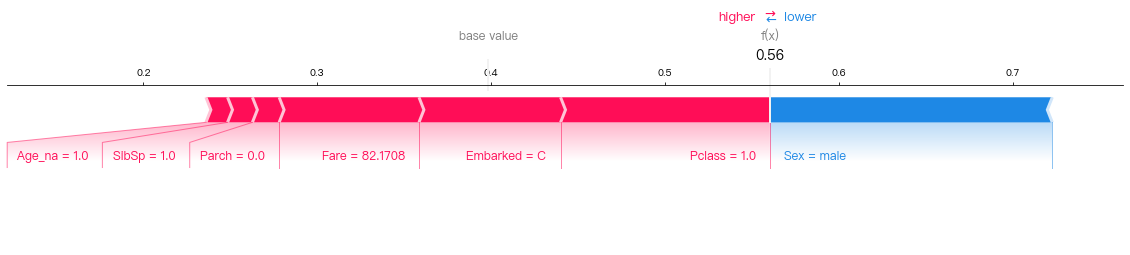

In [7]:

predictor.explain(test_df, row_index=35, class_id=1)

From the visualization above, we can see that:
- his First class status (`Pclass=1`) and his higher-than-average Fare price (suggesting that he is wealthy) are pushing the model higher towards predicting **Survived**. 
- the fact that he is a `Male` pushes the model to lower its prediction towards **NOT Survived**.
- For these reasons, this is a border-line and uncertain prediction.

## Regression

In [ ]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

import urllib.request
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)


import ktrain
from ktrain import tabular

In [11]:
## loading data
train_df = pd.read_csv('housing_price/train.csv', index_col=0)
train_df.head()

train_df.drop(['Alley','PoolQC','MiscFeature','Fence','FireplaceQu','Utilities'], 1, inplace=True)
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


In [13]:

trn, val, preproc = tabular.tabular_from_df(train_df, is_regression=True, 
                                             label_columns='SalePrice', random_state=42)

processing train: 1309 rows x 74 columns

The following integer column(s) are being treated as categorical variables:
['MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
To treat any of these column(s) as numerical, cast the column to float in DataFrame or CSV
 and re-run tabular_from* function.

processing test: 151 rows x 74 columns


Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.


In [14]:
model = tabular.tabular_regression_model('mlp', trn)
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=128)

done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/16
10/10 [==============================] - 1s 59ms/step - loss: 38401822720.0000 - mae: 179885.9688
Epoch 2/16
10/10 [==============================] - 1s 59ms/step - loss: 38854602752.0000 - mae: 180217.5781
Epoch 3/16
10/10 [==============================] - 1s 64ms/step - loss: 39302262784.0000 - mae: 181231.9531
Epoch 4/16
10/10 [==============================] - 1s 63ms/step - loss: 38597410816.0000 - mae: 180044.4062
Epoch 5/16
10/10 [==============================] - 1s 59ms/step - loss: 38854549504.0000 - mae: 180217.4375
Epoch 6/16
10/10 [==============================] - 1s 54ms/step - loss: 39011803136.0000 - mae: 180591.7188
Epoch 7/16
10/10 [==============================] - 1s 63ms/step - loss: 38651219968.0000 - mae: 179554.1562
Epoch 8/16
10/10 [==============================] - 1s 63ms/step - loss: 39466024960.0000 - mae: 181399.4844
Epoch 9/16
10/10 [===========================

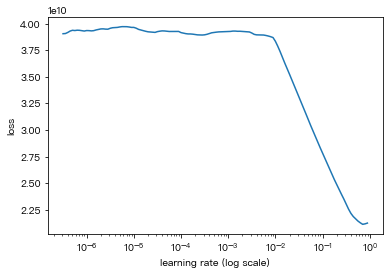

In [15]:
learner.lr_find(show_plot=True, max_epochs=16)


In [17]:
## Inspect the loss plot above
learner.autofit(1e-1)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.1...
Epoch 1/1024
11/11 [==============================] - 1s 98ms/step - loss: 1965156608.0000 - mean_absolute_error: 27892.3418 - val_loss: 1342951296.0000 - val_mean_absolute_error: 28105.6816
Epoch 2/1024
11/11 [==============================] - 1s 95ms/step - loss: 1654379008.0000 - mean_absolute_error: 26724.2051 - val_loss: 727584256.0000 - val_mean_absolute_error: 18240.2422
Epoch 3/1024
11/11 [==============================] - 1s 91ms/step - loss: 1267788032.0000 - mean_absolute_error: 22878.1074 - val_loss: 1009269056.0000 - val_mean_absolute_error: 24026.8105
Epoch 4/1024
11/11 [==============================] - 1s 95ms/step - loss: 1265481984.0000 - mean_absolute_error: 22751.0703 - val_loss: 683911808.0000 - val_mean_absolute_error: 17786.5879
Epoch 5/1024
11/11 [==============================] - 1s

In [18]:
learner.evaluate(test_data=val)

%s is not supported by validate/evaluate - falling back to MAE


[('mae', 17155.113)]

In [19]:
predictor = ktrain.get_predictor(learner.model, preproc)

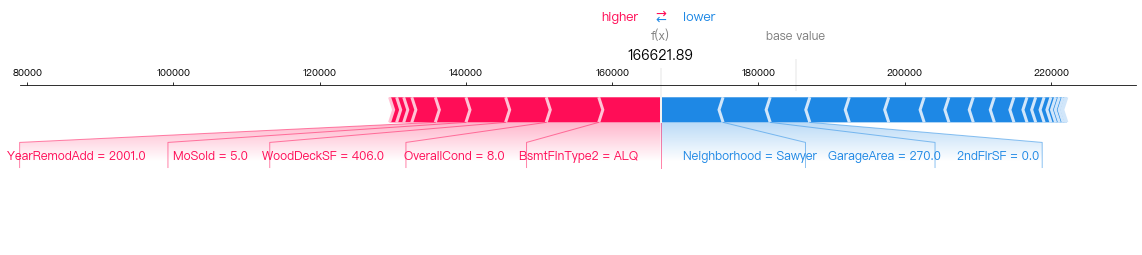

In [21]:
predictor.explain(train_df, row_index=25)

## References

- [*ktrain* Module](https://github.com/amaiya/ktrain)
- [Explainable AI in *ktrain*](https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-A2-explaining-predictions.ipynb)
- [*ktrain* tutorial notebook on tabular models](https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-08-tabular_classification_and_regression.ipynb)